In [ ]:
#%%
import wandb
from tqdm import tqdm
import torch
import os
import shutil
import matplotlib.pyplot as plt
from devinterp.slt import estimate_learning_coeff, estimate_learning_coeff_with_summary
from devinterp.optim import SGLD
from common.env.procgen_wrappers import *
from common.logger import Logger
from common.storage import Storage
from common.model import NatureModel, ImpalaModel
from common.policy import CategoricalPolicy, CategoricalValueNetwork
from common import set_global_seeds, set_global_log_levels

import os, time, yaml, argparse
import gym
from procgen import ProcgenEnv
import random
import torch
from agents.ppo import PPO as AGENT
import random
import yaml
from devinterp.utils import plot_trace
import pickle
from devinterp.slt.gradient import GradientDistribution
from matplotlib.collections import PatchCollection
import matplotlib.ticker as ticker
from devinterp.slt.norms import GradientNorm
from devinterp.slt.llc import LLCEstimator, OnlineLLCEstimator
from devinterp.slt import sample

plt.rcParams["figure.figsize"]=15,12  # note: this cell may need to be re-run after creating a plot to take effect

# epsilons = np.logspace(-4, -11, 10)
# gammas = np.logspace(1, 6, 10)
# num_chains = 8
# num_draws = 2000

epsilons = [1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
gammas = [1e3]
num_chains = 3
num_draws = 200
device = "cuda:0"

In [ ]:
def plot_trace_and_save(trace, y_axis, name, x_axis='step', title=None, plot_mean=True, plot_std=True, fig_size=(12, 9), true_lc=None):
    num_chains, num_draws = trace.shape
    sgld_step = list(range(num_draws))

    plt.figure(figsize=fig_size)

    if true_lc:
        plt.axhline(y=true_lc, color='r', linestyle='dashed')
    
    # trace
    for i in range(num_chains):
        draws = trace[i]
        plt.plot(sgld_step, draws, linewidth=1, label=f'chain {i}')

    # mean
    if plot_mean:
        mean = np.mean(trace, axis=0)
        plt.plot(sgld_step, mean, color='black', linestyle='--', linewidth=2, label='mean', zorder=3)
    
    # std
    if plot_std:
        std = np.std(trace, axis=0)
        plt.fill_between(sgld_step, mean - std, mean + std, color='gray', alpha=0.3, zorder=2)

    if title is None:
        title = f'{y_axis} values over sampling draws'
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))    
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.tight_layout()
    plt.savefig(name)
    plt.show()
    plt.close()

# def estimate_learning_coeff(
#     model: torch.nn.Module,
#     loader: DataLoader,
#     criterion: Callable,
#     sampling_method: Type[torch.optim.Optimizer] = SGLD,
#     optimizer_kwargs: Optional[Dict[str, Union[float, Literal["adaptive"]]]] = None,
#     num_draws: int = 100,
#     num_chains: int = 10,
#     num_burnin_steps: int = 0,
#     num_steps_bw_draws: int = 1,
#     cores: int = 1,
#     seed: Optional[Union[int, List[int]]] = None,
#     device: torch.device = torch.device("cpu"),
#     verbose: bool = True,
#     callbacks: List[Callable] = [],
# ) -> float:

# og run made with:
# python train.py --exp_name hard-run --env_name maze_aisc --param_name easy --num_levels 0 --distribution_mode easy --num_timesteps 200000000 --num_checkpoints 1000

# Excess defaults from train.py for reference:
#     parser.add_argument('--exp_name',         type=str, default = 'test', help='experiment name')
#     parser.add_argument('--env_name',         type=str, default = 'starpilot', help='environment ID')
#     parser.add_argument('--start_level',      type=int, default = int(0), help='start-level for environment')
#     parser.add_argument('--num_levels',       type=int, default = int(0), help='number of training levels for environment')
#     parser.add_argument('--distribution_mode',type=str, default = 'easy', help='distribution mode for environment')
#     parser.add_argument('--param_name',       type=str, default = 'easy-200', help='hyper-parameter ID')
#     parser.add_argument('--device',           type=str, default = 'gpu', required = False, help='whether to use gpu')
#     parser.add_argument('--gpu_device',       type=int, default = int(0), required = False, help = 'visible device in CUDA')
#     parser.add_argument('--num_timesteps',    type=int, default = int(25000000), help = 'number of training timesteps')
#     parser.add_argument('--seed',             type=int, default = random.randint(0,9999), help='Random generator seed')
#     parser.add_argument('--log_level',        type=int, default = int(40), help='[10,20,30,40]')
#     parser.add_argument('--num_checkpoints',  type=int, default = int(1), help='number of checkpoints to store')

def get_model_number(model_name):
    # model is of format model_<number>:v<version>
    return int(model_name.split('_')[1].split(':')[0])

def gradient_single_plot(gradients, param_name: str, color='blue', plot_zero=True, chain: int = None, filename = None):
    grad_dist = gradients.grad_dists[param_name]
    if chain is not None:
        max_count = grad_dist[chain].max()
    else:
        max_count = grad_dist.sum(axis=0).max()

    def get_color_alpha(count):
        if count == 0:
            return torch.tensor(0).to(gradients.device)
        min_alpha = 0.35
        max_alpha = 0.85
        return (count / max_count) * (max_alpha - min_alpha) + min_alpha
    
    def build_rect(count, bin_min, bin_max, draw):
        alpha = get_color_alpha(count)
        pos = (draw, bin_min)
        height = bin_max - bin_min
        width = 1
        return plt.Rectangle(pos, width, height, color=color, alpha=alpha.cpu().numpy().item(), linewidth=0)
    
    _, ax = plt.subplots()
    patches = []
    for draw in range(gradients.num_draws):
        for pos in range(gradients.num_bins):
            bin_min = gradients.min_grad + pos * gradients.bin_size
            bin_max = bin_min + gradients.bin_size
            if chain is None:
                count = grad_dist[:, draw, pos].sum()
            else:
                count = grad_dist[chain, draw, pos]
            if count != 0:
                rect = build_rect(count, bin_min, bin_max, draw)
                patches.append(rect)
    patches = PatchCollection(patches, match_original=True)
    ax.add_collection(patches)

    # note that these y min/max values are relative to *all* gradients, not just the ones for this param
    y_min = gradients.min_grad
    y_max = gradients.max_grad
    # ensure the 0 line is visible
    y_min = y_min if y_min < 0 else -y_max
    y_max = y_max if y_max > 0 else -y_min
    plt.ylim(y_min, y_max)

    plt.xlim(0, gradients.num_draws)
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    if plot_zero:
        plt.axhline(color='black', linestyle=':', linewidth=1)

    plt.xlabel('Sampler steps')
    plt.ylabel('gradient distribution')
    plt.title(f'Distribution of {param_name} gradients at each sampler step')

    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

def get_artifact_network_and_data(artifact_number, datapoints=100, batch_size=100, download=True):
    artifacts = run.logged_artifacts()

    if download:
        artifact = artifacts[artifact_number]
        artifact_to_download = api.artifact(f"{project_name}/{artifact.name}", type="model")
        artifact_dir = artifact_to_download.download()
        model_file = f"{artifact_dir}/{artifact.name[:-3]}.pth"
    else:
        artifacts_files = os.listdir("models")
        model_file = f"models/{artifacts_files[artifact_number]}/{artifacts_files[artifact_number]}"

    hidden_state_dim = 0
    observation_space = env.observation_space
    observation_shape = observation_space.shape
    storage = Storage(observation_shape, hidden_state_dim, n_steps, n_envs, device)

    loaded_checkpoint = torch.load(model_file)
    model = ImpalaModel(in_channels = observation_shape[0])
    policy = CategoricalPolicy(model, False, env.action_space.n)
    if "state_dict" in loaded_checkpoint:
        policy.load_state_dict(loaded_checkpoint['state_dict'])
    elif "model_state_dict" in loaded_checkpoint:
        policy.load_state_dict(loaded_checkpoint['model_state_dict'])
    policy.to(device)
    agent = AGENT(env, policy, logger, storage, device, num_checkpoints, **hyperparameters)

    dataloader, dataset = agent.generate_data_loader(datapoints, batch_size)
    value_network = CategoricalValueNetwork(model, False)
    if "state_dict" in loaded_checkpoint:
        loaded_checkpoint['state_dict'] = {k: v for k,v in loaded_checkpoint['state_dict'].items() if "policy" not in k}
        value_network.load_state_dict(loaded_checkpoint['state_dict'])
    elif "model_state_dict" in loaded_checkpoint:
        loaded_checkpoint['model_state_dict'] = {k: v for k,v in loaded_checkpoint['model_state_dict'].items() if "policy" not in k}
        value_network.load_state_dict(loaded_checkpoint['model_state_dict'])
    return dataloader, dataset, value_network

def optimize_value_network(value_network, dataloader, epochs=50, lr=1e-5):
    value_network.to(device)
    optimizer = torch.optim.Adam(value_network.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    # Initialize a new wandb run
    wandb.init(
        project="procgen-lambdahat-estimation", 
        name="optimize_that_thing!", 
        mode="offline"
    )

    for epoch in tqdm(range(epochs)):
        for batch_idx, batch in enumerate(dataloader):
            optimizer.zero_grad()
            observations, returns = batch
            observations = observations.to(device)
            returns = returns.to(device)
            values_pred = value_network(observations)
            value_loss = criterion(values_pred, returns)

            value_loss.backward()
            optimizer.step()

            # Calculate gradients statistics
            grad_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()) for p in value_network.parameters() if p.grad is not None]))
            grad_mean = torch.mean(torch.stack([torch.mean(p.grad.detach()) for p in value_network.parameters() if p.grad is not None]))
            grad_std = torch.std(torch.stack([torch.std(p.grad.detach()) for p in value_network.parameters() if p.grad is not None]))

            # Log the loss and gradients
            wandb.log({
                "epoch": epoch,
                "batch": batch_idx,
                "value_loss": value_loss.item(),
                "value_network_grad_norm": grad_norm, 
                "value_network_grad_mean": grad_mean, 
                "value_network_grad_std": grad_std,
                **{f"gradients/{name}": wandb.Histogram(p.grad.cpu().numpy()) for name, p in value_network.named_parameters() if p.grad is not None}
            })

    wandb.finish()
    return value_network    
criterion = torch.nn.MSELoss()

def run_callbacks(model, epsilon, gamma, dataloader, num_chains, num_draws, dataset, callbacks, device):
    optim_kwargs = {
        "lr": epsilon,
        "elasticity": gamma,
        "temperature": "adaptive",
        "num_samples": len(dataset), 
        "save_noise": True
    }
    
    if callbacks is None:
        llc_estimator = OnlineLLCEstimator(num_chains, num_draws, len(dataset), device=device)
        callbacks = [llc_estimator]

    sample(
        model=model, 
        loader=dataloader, 
        criterion = criterion, 
        optimizer_kwargs = optim_kwargs,
        sampling_method = SGLD, 
        num_chains = num_chains,
        num_draws = num_draws, 
        callbacks = callbacks, 
        device=device
    )
    
    results = {}

    for callback in callbacks:
        if hasattr(callback, "sample"):
            results.update(callback.sample())
    return results
    

def estimate_llcs_sweeper(model, epsilons, gammas, dataloader, dataset):
    results = {}
    for epsilon in epsilons:
        for gamma in gammas:
            print(f"epsilon: {epsilon}, gamma: {gamma}, model 8000")
            optim_kwargs = dict(
                lr=epsilon,
                noise_level=1.0,
                elasticity=gamma,
                num_samples=len(dataset),
                temperature="adaptive",
            )
            pair = (epsilon, gamma)
            # try:
            grad_norm = GradientNorm(
                num_chains = num_chains, 
                num_draws = num_draws, 
                device=device
            )
            llc_estimater = LLCEstimator(
                num_chains = num_chains,
                num_draws = num_draws, 
                device = device
            )
            callbacks = [llc_estimater, grad_norm]
            results[pair] = run_callbacks(
                train_loader=dataloader,
                train_data=dataset, 
                weights = model.parameters(),
                criterion=criterion,

                
            )
            results[pair] = estimate_learning_coeff_with_summary(
                model=model,
                loader=dataloader,
                criterion=criterion,
                sampling_method=SGLD,
                optimizer_kwargs=optim_kwargs,
                num_chains=num_chains,
                num_draws=num_draws,
                device=device,
                online=True,
                callbacks=callbacks
            )
            # except:
            #     print("failed")
            #     results[pair] = None
    return results

def plot_single_graph(result, filename=None, title=''):
    llc_color = 'teal'
    fig, axs = plt.subplots(1, 1)
    # plot loss traces
    loss_traces = result['loss/trace']
    for trace in loss_traces:
        init_loss = trace[0]
        zeroed_trace = trace - init_loss
        sgld_steps = list(range(len(trace)))
        axs.plot(sgld_steps, zeroed_trace)

    # plot llcs
    means = result['llc/means']
    stds = result['llc/stds']
    sgld_steps = list(range(len(means)))
    axs2 = axs.twinx() 
    axs2.plot(sgld_steps, means, color=llc_color, linestyle='--', linewidth=2, label=f'llc', zorder=3)
    axs2.fill_between(sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2)

    # center zero, assume zero is in the range of both y axes already
    y1_min, y1_max = axs.get_ylim()
    y2_min, y2_max = axs2.get_ylim()
    y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
    y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
    percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
    y1_amt_to_add = (y1_max - y1_min) * percent_to_add
    y2_amt_to_add = (y2_max - y2_min) * percent_to_add
    if y1_zero_ratio < y2_zero_ratio:
        # add to bottom of y1 and top of y2
        y1_min -= y1_amt_to_add
        y2_max += y2_amt_to_add
    elif y2_zero_ratio < y1_zero_ratio:
        # add to bottom of y2 and top of y1
        y2_min -= y2_amt_to_add
        y1_max += y1_amt_to_add
    axs.set_ylim(y1_min, y1_max)
    axs2.set_ylim(y2_min, y2_max)
    axs.set_xlabel('SGLD time step')
    axs.set_ylabel('loss')
    axs2.set_ylabel('llc', color=llc_color)
    axs2.tick_params(axis='y', labelcolor=llc_color)
    axs.axhline(color='black', linestyle=':')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()

def plot_sweep_single_model(results, epsilons, gammas, filename, **kwargs):
    llc_color = 'teal'
    fig, axs = plt.subplots(len(epsilons), len(gammas))

    for i, epsilon in enumerate(epsilons):
        for j, gamma in enumerate(gammas):
            result = results[(epsilon, gamma)]
            if result is None:
                continue
            # plot loss traces
            loss_traces = result['loss/trace']
            for trace in loss_traces:
                init_loss = trace[0]
                zeroed_trace = trace - init_loss
                sgld_steps = list(range(len(trace)))
                axs[i, j].plot(sgld_steps, zeroed_trace)

            # plot llcs
            means = result['llc/means']
            stds = result['llc/stds']
            sgld_steps = list(range(len(means)))
            axs2 = axs[i, j].twinx() 
            axs2.plot(sgld_steps, means, color=llc_color, linestyle='--', linewidth=2, label=f'llc', zorder=3)
            axs2.fill_between(sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2)

            # center zero, assume zero is in the range of both y axes already
            y1_min, y1_max = axs[i, j].get_ylim()
            y2_min, y2_max = axs2.get_ylim()
            y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
            y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
            percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
            y1_amt_to_add = (y1_max - y1_min) * percent_to_add
            y2_amt_to_add = (y2_max - y2_min) * percent_to_add
            if y1_zero_ratio < y2_zero_ratio:
                # add to bottom of y1 and top of y2
                y1_min -= y1_amt_to_add
                y2_max += y2_amt_to_add
            elif y2_zero_ratio < y1_zero_ratio:
                # add to bottom of y2 and top of y1
                y2_min -= y2_amt_to_add
                y1_max += y1_amt_to_add
            axs[i, j].set_ylim(y1_min, y1_max)
            axs2.set_ylim(y2_min, y2_max)
            
            axs[i, j].set_title(f"$\epsilon$ = {epsilon} : $\gamma$ = {gamma}")
            # only show x axis label on last row
            if i == len(epsilons) - 1:
                axs[i, j].set_xlabel('SGLD time step')
            axs[i, j].set_ylabel('loss')
            axs2.set_ylabel('llc', color=llc_color)
            axs2.tick_params(axis='y', labelcolor=llc_color)
    if kwargs['title']:
        fig.suptitle(kwargs['title'], fontsize=16)
    plt.tight_layout()
    plt.savefig(filename)

In [ ]:
# Set your specific run ID here
run_id = "jp9tjfzd"
project_name = "procgen"

# Initialize wandb API
api = wandb.Api()

# Fetch the run
run = api.run(f"{project_name}/{run_id}")

torch.manual_seed(1)

####################
## HYPERPARAMETERS #
#################### 
param_name = 'easy'
gpu_device = int(0)
env_name = "maze_aisc"
start_level = 0
num_levels = 0
distribution_mode = "easy"
exp_name = "hard-run"
seed = random.randint(0,9999)
num_checkpoints = 0

print('[LOADING HYPERPARAMETERS...]')
with open('hyperparams/procgen/config.yml', 'r') as f:
    hyperparameters = yaml.safe_load(f)[param_name]
for key, value in hyperparameters.items():
    print(key, ':', value)

############
## DEVICE ##
############
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_device)
device = torch.device('cuda')

#################
## ENVIRONMENT ##
#################
print('INITIALIZAING ENVIRONMENTS...')
n_steps = hyperparameters.get('n_steps', 256)
n_envs = hyperparameters.get('n_envs', 64)
# By default, pytorch utilizes multi-threaded cpu
# Procgen is able to handle thousand of steps on a single core
torch.set_num_threads(1)
env = ProcgenEnv(num_envs=n_envs,
                    env_name=env_name,
                    start_level=start_level,
                    num_levels=num_levels,
                    distribution_mode=distribution_mode, 
                    rand_region = 5) 
normalize_rew = hyperparameters.get('normalize_rew', True)
env = VecExtractDictObs(env, "rgb")
if normalize_rew:
    env = VecNormalize(env, ob=False) # normalizing returns, but not the img frames.
env = TransposeFrame(env)
env = ScaledFloatFrame(env)

############
## LOGGER ##
############
print('INITIALIZAING LOGGER...')
logdir = 'procgen/' + env_name + '/' + exp_name + '/' + 'seed' + '_' + \
            str(seed) + '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join('logs', logdir)
if not (os.path.exists(logdir)):
    os.makedirs(logdir)
logger = Logger(n_envs, logdir)


In [ ]:
artifact_no = 8000
print(f"Fetching model and dataloader {artifact_no}")
dataloader, dataset, value_network = get_artifact_network_and_data(
    artifact_number = artifact_no, 
    datapoints = 4000, 
    batch_size = 1000, 
    download=False
)
print(len(dataset))
print(f"Optimizing value network {artifact_no}")
value_network = optimize_value_network(value_network, dataloader, epochs=200)
torch.save(value_network.state_dict(), f'value_network_local_min_{artifact_no}.pth')

# print layers of value network
for name, param in value_network.named_parameters():
    print(name, param.shape)

In [ ]:
from devinterp.slt.callback import validate_callbacks

In [ ]:
# epsilons = [1e-8, 1e-9, 1e-10, 1e-11]
# gammas = [1.0, 10, 100, 1000, 10000, 100000]
epsilons = [1e-6]
gammas = [1e5]
num_chains = 3
num_draws = 2000

In [58]:
epsilon = 1e-6
gamma = 8e5
num_chains = 3
num_draws = 200
llcs = []
for i in tqdm(range(100)):
    llc_estimator = OnlineLLCEstimator(num_chains, num_draws, len(dataset), device=device)
    grad_norm = GradientNorm(num_chains, num_draws, device=device)
    callbacks = [llc_estimator, grad_norm]
    result = run_callbacks(
        model=value_network,
        epsilon=epsilon,
        gamma=gamma,
        dataloader=dataloader,
        num_chains=num_chains,
        num_draws=num_draws,
        dataset=dataset,
        callbacks=callbacks,
        device=device
    )
    llcs.append(result['llc/means'][-1])
    print(result['llc/means'][-1])



  1%|          | 1/100 [00:28<47:33, 28.82s/it]

8613.512


  2%|▏         | 2/100 [00:57<47:22, 29.01s/it]

7901.0625


  3%|▎         | 3/100 [01:27<46:55, 29.03s/it]

7909.5054


  4%|▍         | 4/100 [01:56<46:29, 29.06s/it]

9147.648


  5%|▌         | 5/100 [02:25<46:02, 29.08s/it]

8750.555


  6%|▌         | 6/100 [02:54<45:34, 29.09s/it]

8035.665


  7%|▋         | 7/100 [03:23<45:06, 29.11s/it]

8838.008


  8%|▊         | 8/100 [03:52<44:38, 29.11s/it]

8125.265


  9%|▉         | 9/100 [04:21<44:10, 29.13s/it]

8669.16


 10%|█         | 10/100 [04:50<43:43, 29.15s/it]

8354.004


 11%|█         | 11/100 [05:20<43:18, 29.19s/it]

8169.173


 12%|█▏        | 12/100 [05:49<42:48, 29.18s/it]

7908.3066


 13%|█▎        | 13/100 [06:18<42:19, 29.18s/it]

8373.191


 14%|█▍        | 14/100 [06:47<41:50, 29.19s/it]

8372.605


 15%|█▌        | 15/100 [07:16<41:20, 29.18s/it]

8749.959


 16%|█▌        | 16/100 [07:46<40:51, 29.19s/it]

8393.664


 17%|█▋        | 17/100 [08:15<40:22, 29.19s/it]

8867.58


 18%|█▊        | 18/100 [08:44<39:52, 29.18s/it]

8109.464


 19%|█▉        | 19/100 [09:13<39:25, 29.21s/it]

7895.325


 20%|██        | 20/100 [09:43<38:56, 29.21s/it]

8480.669


 21%|██        | 21/100 [10:12<38:28, 29.22s/it]

8329.572


 22%|██▏       | 22/100 [10:41<37:58, 29.21s/it]

8148.8623


 23%|██▎       | 23/100 [11:12<38:00, 29.62s/it]

8383.684


 24%|██▍       | 24/100 [11:46<39:14, 30.98s/it]

8359.635


 25%|██▌       | 25/100 [12:20<40:05, 32.08s/it]

8096.6885


 26%|██▌       | 26/100 [12:49<38:29, 31.21s/it]

8114.7827


 27%|██▋       | 27/100 [13:19<37:14, 30.61s/it]

8469.666


 28%|██▊       | 28/100 [14:09<43:56, 36.62s/it]

8268.955


 29%|██▉       | 29/100 [15:05<50:07, 42.36s/it]

7717.664


 30%|███       | 30/100 [16:09<56:51, 48.73s/it]

8304.129


 31%|███       | 31/100 [17:04<58:09, 50.57s/it]

8465.01


 32%|███▏      | 32/100 [17:58<58:44, 51.83s/it]

8182.4233


 33%|███▎      | 33/100 [19:03<1:02:15, 55.76s/it]

8327.554


 34%|███▍      | 34/100 [19:58<1:00:58, 55.43s/it]

8441.107


 35%|███▌      | 35/100 [20:53<59:59, 55.37s/it]  

8446.422


 36%|███▌      | 36/100 [21:56<1:01:31, 57.68s/it]

8303.054


 37%|███▋      | 37/100 [22:52<59:54, 57.06s/it]  

8006.285


 38%|███▊      | 38/100 [23:48<58:48, 56.91s/it]

8245.348


 39%|███▉      | 39/100 [24:51<59:27, 58.49s/it]

8365.826


 40%|████      | 40/100 [25:46<57:37, 57.63s/it]

8070.1934


 41%|████      | 41/100 [26:43<56:33, 57.52s/it]

8722.705


 42%|████▏     | 42/100 [27:45<56:41, 58.65s/it]

8194.849


 43%|████▎     | 43/100 [28:40<54:53, 57.78s/it]

8659.249


 44%|████▍     | 44/100 [29:38<53:55, 57.78s/it]

8071.118


 45%|████▌     | 45/100 [30:39<53:46, 58.65s/it]

8422.828


 46%|████▌     | 46/100 [31:35<52:00, 57.79s/it]

7905.912


 47%|████▋     | 47/100 [32:34<51:19, 58.10s/it]

9017.371


 48%|████▊     | 48/100 [33:32<50:29, 58.25s/it]

7995.995


 49%|████▉     | 49/100 [34:28<48:51, 57.48s/it]

8054.5654


 50%|█████     | 50/100 [35:27<48:22, 58.05s/it]

8110.568


 51%|█████     | 51/100 [36:26<47:41, 58.40s/it]

8487.244


 52%|█████▏    | 52/100 [37:22<46:03, 57.56s/it]

8261.506


 53%|█████▎    | 53/100 [38:22<45:39, 58.29s/it]

8623.445


 54%|█████▍    | 54/100 [39:20<44:42, 58.31s/it]

8208.467


 55%|█████▌    | 55/100 [40:16<43:07, 57.51s/it]

9253.49


 56%|█████▌    | 56/100 [41:17<42:59, 58.62s/it]

8579.098


 57%|█████▋    | 57/100 [42:15<41:48, 58.34s/it]

8141.65


 58%|█████▊    | 58/100 [43:10<40:14, 57.48s/it]

8756.635


 59%|█████▉    | 59/100 [44:12<40:08, 58.74s/it]

8682.203


 60%|██████    | 60/100 [45:09<38:45, 58.15s/it]

7907.1895


 61%|██████    | 61/100 [46:04<37:17, 57.38s/it]

8850.765


 62%|██████▏   | 62/100 [47:07<37:16, 58.87s/it]

8823.761


 63%|██████▎   | 63/100 [48:03<35:48, 58.06s/it]

8243.256


 64%|██████▍   | 64/100 [48:59<34:23, 57.33s/it]

8493.042


 65%|██████▌   | 65/100 [50:02<34:32, 59.20s/it]

8479.512


 66%|██████▌   | 66/100 [50:57<32:51, 57.98s/it]

8503.137


 67%|██████▋   | 67/100 [51:52<31:23, 57.08s/it]

8390.948


 68%|██████▊   | 68/100 [52:57<31:41, 59.42s/it]

8772.82


 69%|██████▉   | 69/100 [53:51<29:54, 57.88s/it]

8412.991


 70%|███████   | 70/100 [54:46<28:28, 56.96s/it]

8389.936


 71%|███████   | 71/100 [55:50<28:28, 58.92s/it]

8226.168


 72%|███████▏  | 72/100 [56:45<27:00, 57.89s/it]

8588.015


 73%|███████▎  | 73/100 [57:41<25:45, 57.25s/it]

8407.821


 74%|███████▍  | 74/100 [58:44<25:31, 58.89s/it]

8456.324


 75%|███████▌  | 75/100 [59:39<24:07, 57.91s/it]

8030.6304


 76%|███████▌  | 76/100 [1:00:36<22:59, 57.49s/it]

8290.699


 77%|███████▋  | 77/100 [1:01:38<22:32, 58.81s/it]

8188.59


 78%|███████▊  | 78/100 [1:02:33<21:12, 57.83s/it]

8419.949


 79%|███████▉  | 79/100 [1:03:31<20:11, 57.68s/it]

8268.63


 80%|████████  | 80/100 [1:04:32<19:34, 58.71s/it]

8092.0015


 81%|████████  | 81/100 [1:05:27<18:18, 57.81s/it]

8056.4272


 82%|████████▏ | 82/100 [1:06:26<17:23, 57.95s/it]

8169.345


 83%|████████▎ | 83/100 [1:07:26<16:38, 58.71s/it]

8365.326


 84%|████████▍ | 84/100 [1:08:22<15:24, 57.76s/it]

8123.412


 85%|████████▌ | 85/100 [1:09:21<14:31, 58.13s/it]

8207.546


 86%|████████▌ | 86/100 [1:10:09<12:53, 55.27s/it]

8150.173


 87%|████████▋ | 87/100 [1:10:38<10:16, 47.44s/it]

8063.57


 88%|████████▊ | 88/100 [1:11:08<08:23, 41.97s/it]

8104.8257


 89%|████████▉ | 89/100 [1:11:37<06:59, 38.13s/it]

7975.9756


 90%|█████████ | 90/100 [1:12:06<05:54, 35.44s/it]

8998.363


 91%|█████████ | 91/100 [1:12:35<05:02, 33.59s/it]

8334.881


 92%|█████████▏| 92/100 [1:13:04<04:18, 32.26s/it]

8884.666


 93%|█████████▎| 93/100 [1:13:34<03:39, 31.32s/it]

8663.977


 94%|█████████▍| 94/100 [1:14:03<03:04, 30.68s/it]

8064.538


 95%|█████████▌| 95/100 [1:14:32<02:31, 30.22s/it]

9093.949


 96%|█████████▌| 96/100 [1:15:01<01:59, 29.91s/it]

8753.904


 97%|█████████▋| 97/100 [1:15:30<01:29, 29.69s/it]

8451.4


 98%|█████████▊| 98/100 [1:15:59<00:59, 29.54s/it]

8599.8955


 99%|█████████▉| 99/100 [1:16:29<00:29, 29.48s/it]

7861.1475


100%|██████████| 100/100 [1:16:58<00:00, 46.18s/it]

8733.814


In [ ]:
# making a histogram of the llcs
plt.hist(llcs, bins=20)
plt.show()

In [ ]:
print(f"llc mean: {np.mean(llcs)}, llc std: {np.std(llcs)}")

In [48]:
epsilons = np.logspace(-7, -5, 10)
gammas = np.logspace(4, 6, 10)
print(epsilons)

[1.00000000e-07 1.66810054e-07 2.78255940e-07 4.64158883e-07
 7.74263683e-07 1.29154967e-06 2.15443469e-06 3.59381366e-06
 5.99484250e-06 1.00000000e-05]


Running calibration sweep on model 8000


Chain 2: 100%|██████████| 200/200 [00:09<00:00, 20.82it/s]


Pair: 1e-06, 800000.0 - llc mean: 8785.4912109375, llc std: 1129.9354248046875


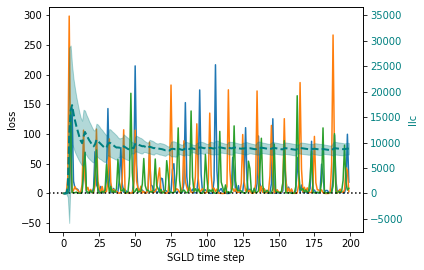

Chain 2: 100%|██████████| 200/200 [00:09<00:00, 20.79it/s]


Pair: 1e-06, 800000.0 - llc mean: 8366.7802734375, llc std: 65.88754272460938


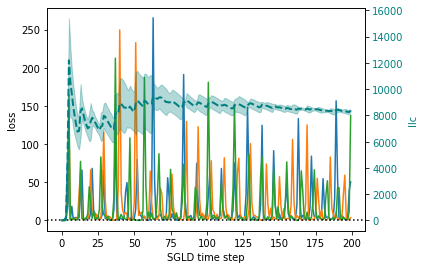

Chain 2: 100%|██████████| 200/200 [00:09<00:00, 20.62it/s]


Pair: 1e-06, 800000.0 - llc mean: 8253.68359375, llc std: 404.50311279296875


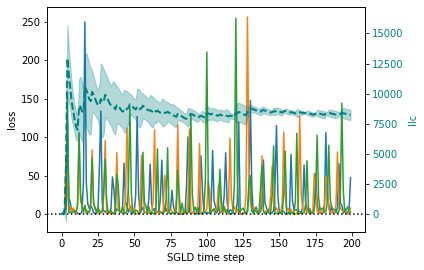

Chain 2: 100%|██████████| 200/200 [00:09<00:00, 20.65it/s]


Pair: 1e-06, 800000.0 - llc mean: 8152.876953125, llc std: 619.253662109375


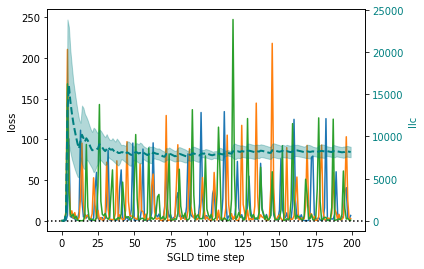

Chain 2: 100%|██████████| 200/200 [00:09<00:00, 20.63it/s]


Pair: 1e-06, 800000.0 - llc mean: 8353.5478515625, llc std: 366.8700866699219


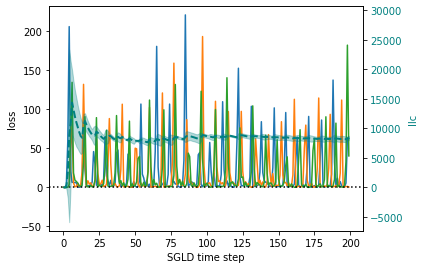

epsilons: 100%|██████████| 1/1 [02:26<00:00, 146.07s/it]


In [56]:
print(f"Running calibration sweep on model {artifact_no}")
# results = estimate_llcs_sweeper(value_network, epsilons, gammas, dataloader, dataset)
# epsilon centered around 1e-6, gamma centered around 1e5 (in log space)
epsilons = [1e-6]
gammas = [8e5, 8e5, 8e5, 8e5, 8e5]
num_draws = 200
num_chains = 3
results = {}
timed_dir = f"calibration_sweeps/{str(time.time())}"
os.makedirs(timed_dir, exist_ok=True)
for epsilon in tqdm(epsilons, desc="epsilons"):
    for gamma in gammas:
        llc_estimator = OnlineLLCEstimator(num_chains, num_draws, len(dataset), device=device)
        grad_norm = GradientNorm(num_chains, num_draws, device=device)
        callbacks = [grad_norm, llc_estimator]
        assert validate_callbacks(callbacks)
        result = run_callbacks(
            model=value_network,
            epsilon=epsilon,
            gamma=gamma,
            dataloader=dataloader,
            num_chains=num_chains,
            num_draws=num_draws,
            dataset=dataset,
            callbacks=callbacks,
            device=device
        )
        print(f"Pair: {epsilon}, {gamma} - llc mean: {result['llc/means'][-1]}, llc std: {result['llc/stds'][-1]}")
        results[(epsilon, gamma)] = result
        plot_single_graph(result)
        with open(f'{timed_dir}/calibration_sweep_results_model_{artifact_no}.pkl', 'wb') as f:
            pickle.dump(results, f)


# print("Fetching model and dataloader 100")
# dataloader, dataset, value_network = get_artifact_network_and_data(artifact_number = 100)

# print("Running calibration sweep on model 100")
# results = estimate_llcs_sweeper(value_network, epsilons, gammas)

# with open('calibration_sweep_results_model_100.pkl', 'wb') as f:
#     pickle.dump(results, f)

# plot_sweep_single_model(
#     results, 
#     epsilons, 
#     gammas, 
#     "calibration_sweep_model_100.png", 
#     title='Calibration sweep of model for lr ($\epsilon$) and elasticity ($\gamma$)'
# )


In [ ]:
# making a table of epsilons, gammas, and their llc stds
for epsilon in epsilons:
    for gamma in gammas:
        pair = (epsilon, gamma)
        result = results[pair]
        if result is None:
            continue
        llc_std = result['llc/stds'].mean()
        llc_mean = result['llc/means'].mean()
        print(f"{pair} & {llc_mean:.3f} & {llc_std:.3f} \\\\")

In [ ]:
print(results[(1e-6, 1e5)]['llc/means'].mean())
print(results[(1e-6, 1e5)]['llc/stds'].mean())

In [ ]:
result = results[(1e-06, 100000.0)]
print(type(result))
print(result)

In [ ]:
with open(f'{timed_dir}/calibration_sweep_results_model_{artifact_no}.pkl', 'rb') as f:
    results = pickle.load(f)
folder_timelog = str(time.time())
os.makedirs(f"calibration_sweep/{folder_timelog}", exist_ok=True)

In [ ]:
plot_sweep_single_model(
    results, 
    epsilons, 
    gammas, 
    f"calibration_sweep_model_{artifact_no}.png", 
    title=f'Calibration sweep of model {artifact_no} for lr ($\epsilon$) and elasticity ($\gamma$)'
)

In [ ]:
for epsilon in epsilons:
    for gamma in gammas:
        llc_trace = results[(epsilon, gamma)]['llc/trace']
        # plot_trace(llc_trace, f'llc_trace ({epsilon}, {gamma})', f"calibration_sweep/{folder_timelog}/llc_trace.png")
        # # gradient_trace = results[(epsilon, gamma)]['gradient_norm/trace']
        # # plot_trace(gradient_trace, f'gradient_trace ({epsilon}, {gamma})', f"calibration_sweep/{folder_timelog}/gradient_trace.png")
        # loss_trace = results[(epsilon, gamma)]['loss/trace']
        # plot_trace(loss_trace, f'loss_trace ({epsilon}, {gamma})', f"calibration_sweep/{folder_timelog}/loss_trace.png")
        plot_single_graph(results[(epsilon, gamma)])

In [ ]:
gradient_trace = result['gradient_norm/trace']
plot_trace(gradient_trace, 'gradient norm', f"calibration_sweep/{folder_timelog}/gradient_trace.png")

In [ ]:
loss_trace = result['loss/trace']
plot_trace(loss_trace, 'loss', f"calibration_sweep/{folder_timelog}/loss_trace.png")

In [ ]:
with open('calibration_sweep_results_model_8000.pkl', 'rb') as f:
    results = pickle.load(f)
folder_timelog = str(time.time())
os.makedirs(f"calibration_sweep/{folder_timelog}", exist_ok=True)
for epsilon in epsilons:
    for gamma in gammas:
        result = results[(epsilon, gamma)]
        if result is None:
            continue
        
        plot_single_graph(
            result, 
            f"calibration_sweep/{folder_timelog}/llc_model_8000_{epsilon}_{gamma}.png",
            title=f"Calibration sweep of model 8000 for lr ($\epsilon$) and elasticity ($\gamma$)"
        )

        gradient_trace = result["gradient_norm/trace"]
        plot_trace_and_save(
            gradient_trace, 
            y_axis="gradient norm", 
            name=f"calibration_sweep/{folder_timelog}/gradient_trace_model_8000_{epsilon}_{gamma}.png"
        )